In [2]:
%cd /scratch/bruingjde/SNAM2021-code/

from constants import *

/scratch/bruingjde/SNAM2021-code


# Size

In [3]:
size = tlp.ProgressParallel(n_jobs=network_count, total=network_count)(
  joblib.delayed(get_size)(network_index) for network_index in network_indices
)
  
size = pd.DataFrame(size)
size

  0%|          | 0/26 [00:00<?, ?it/s]

,nodes,edges,events
1,1824701,8344615,29487744
2,16959,1194440,2322259
3,87273,299220,1148072
4,55387,335708,335708
5,17218,55276,88090
6,6798,214693,290597
7,855165,3358827,23787273
8,55387,335708,335708
9,30398,86312,87627
10,279374,1546540,1729983


# Other stats

In [4]:
stats = get_all_stats(network_indices=network_indices) 
stats = stats[['density', 'degree assortativity', 'average clustering coefficient']]
stats

  0%|          | 0/26 [00:00<?, ?it/s]

,density,degree assortativity,average clustering coefficient
1,0.000005,0.114186,0.632629
2,0.008307,0.059906,0.606845
3,0.000079,-0.166689,0.119342
4,0.000219,0.221522,0.123693
5,0.000373,0.177355,0.642282
6,0.009293,0.010808,0.770476
7,0.000009,0.155727,0.606712
8,0.000219,0.221522,0.123693
9,0.000187,0.008341,0.005286
10,0.000040,-0.055707,0.089571


# Diameter

In [5]:
diameter = get_diameter()
diameter

  0%|          | 0/26 [00:00<?, ?it/s]

{1: 23,
 2: 8,
 3: 14,
 4: 16,
 5: 19,
 6: 11,
 7: 22,
 8: 16,
 9: 12,
 10: 18,
 11: 4,
 12: 5,
 13: 6,
 14: 9,
 16: 14,
 18: 10,
 19: 8,
 20: 14,
 21: 13,
 22: 13,
 23: 12,
 24: 8,
 25: 10,
 28: 11,
 29: 17,
 30: 7}

# Static features

In [6]:
def logistic_regression_I(network_index: int):
  X = dict()
  for heuristic in ['aa', 'cn', 'jc', 'pa']:
    X[heuristic] = np.load(
      f'data/{network_index:02}/features/time_agnostic/{heuristic}.npy')
  X = pd.DataFrame(X)
    
  y = np.load(f'data/{network_index:02}/targets_sampled.npy')
  
  X_train, X_test, y_train, y_test = (
    sklearn.model_selection.train_test_split(X, y))
  pipe = sklearn.pipeline.make_pipeline(
    sklearn.preprocessing.StandardScaler(),
    sklearn.linear_model.LogisticRegression(max_iter=10000)) # type: ignore
  pipe.fit(X_train, y_train)
  
  auc = sklearn.metrics.roc_auc_score(
    y_true=y_test, y_score=pipe.predict_proba(X_test)[:,1]) # type: ignore
  
  return auc

auc_I = {
  network_index: logistic_regression_I(network_index) 
  for network_index in network_indices}
auc_I

{1: 0.6950591181344901,
 2: 0.8158829348714262,
 3: 0.8529147434617432,
 4: 0.7680353276752603,
 5: 0.6896123613519113,
 6: 0.7645705881006963,
 7: 0.7137687872480953,
 8: 0.7621901950431207,
 9: 0.8416315705580619,
 10: 0.8956614062912016,
 11: 0.9349495095919215,
 12: 0.8532715100010496,
 13: 0.73507003387435,
 14: 0.8631473037854211,
 16: 0.879642385585212,
 18: 0.8660606185696988,
 19: 0.918574894644566,
 20: 0.8313618486875333,
 21: 0.66946218711395,
 22: 0.9386836484822418,
 23: 0.9244794716762318,
 24: 0.7789032184980598,
 25: 0.8689186280510981,
 28: 0.8792876637537116,
 29: 0.9070812460678768,
 30: 0.824650696877497}

# Node temporal features

In [7]:
def logistic_regression_I_II(network_index: int, hypergraph: bool):
  X = dict()
  for heuristic in ['aa', 'cn', 'jc', 'pa']:
    X[heuristic] = (
      np.load(
        f'data/{network_index:02}/features/time_agnostic/{heuristic}.npy'))
    
  if hypergraph:
    for time_strategy in time_strategies:
      for nodepair_strategy in nodepair_strategies:
        for aggregation_strategy in ['m0', 'm1', 'm2', 'm3', 'q0', 'q25', 'q50', 'q75', 'q100']:
          X[(time_strategy, nodepair_strategy, aggregation_strategy)] = (
            np.load(
              f'data/{network_index:02}/features/time_node/'
              f'{time_strategy}_{nodepair_strategy}_{aggregation_strategy}.npy'
            ))
  else:
    for time_strategy in time_strategies:
      for nodepair_strategy in nodepair_strategies:
          X[(time_strategy, nodepair_strategy)] = (
            np.load(
              f'data/{network_index:02}/features/time_node/'
              f'{time_strategy}_{nodepair_strategy}.npy'))
    
  X = pd.DataFrame(X)
    
  y = np.load(f'data/{network_index:02}/targets_sampled.npy')
  
  X_train, X_test, y_train, y_test = (
    sklearn.model_selection.train_test_split(X, y))
  pipe = sklearn.pipeline.make_pipeline(
    sklearn.preprocessing.StandardScaler(),
    sklearn.linear_model.LogisticRegression(max_iter=10000))
  pipe.fit(X_train, y_train)
  
  auc = sklearn.metrics.roc_auc_score(
    y_true=y_test, y_score=pipe.predict_proba(X_test)[:,1])
  
  return auc

auc_I_II = {
  network_index: (
    logistic_regression_I_II(
      network_index, hypergraph=network_index in hypergraph_indices
    )
  )
  for network_index in network_indices
}
auc_I_II

{1: 0.7935637370197924,
 2: 0.8674497707426095,
 3: 0.9113961823389174,
 4: 0.78528215789744,
 5: 0.7341291067503813,
 6: 0.816033730565397,
 7: 0.8158935035740142,
 8: 0.7799954196853347,
 9: 0.8681024516882607,
 10: 0.9173342553812438,
 11: 0.940976230492197,
 12: 0.9025159240305858,
 13: 0.8752423275993934,
 14: 0.9356337795373988,
 16: 0.9378374174917227,
 18: 0.9436175333949156,
 19: 0.9330833156909594,
 20: 0.9426430012845204,
 21: 0.7291502264036225,
 22: 0.9724187278216027,
 23: 0.9617610196933413,
 24: 0.9498123524863595,
 25: 0.9387265207849734,
 28: 0.8860929528361022,
 29: 0.9245003079200492,
 30: 0.8436458077254009}

# Edge temporal features

In [8]:
def logistic_regression_III(network_index: int, hypergraph: bool):
  X = dict()
  
  for heuristic in ['aa', 'cn', 'jc', 'pa']:  
    for time_strategy in time_strategies:
      if hypergraph:
        for aggregation_strategy in ['m0', 'm1', 'q0', 'q25', 'q50', 'q75', 'q100']:
            X[(heuristic, time_strategy, aggregation_strategy)] = np.load(
                f'data/{network_index:02}/features/time_edge/'
                f'{heuristic}_{time_strategy}_{aggregation_strategy}.npy')
      else:
        X[(heuristic, time_strategy)] = np.load(
          f'data/{network_index:02}/features/time_edge/'
          f'{heuristic}_{time_strategy}.npy')
    
  X = pd.DataFrame(X)
    
  y = np.load(f'data/{network_index:02}/targets_sampled.npy')
  
  X_train, X_test, y_train, y_test = (
    sklearn.model_selection.train_test_split(X, y))
  pipe = sklearn.pipeline.make_pipeline(
    sklearn.preprocessing.StandardScaler(),
    sklearn.linear_model.LogisticRegression(max_iter=10000))
  pipe.fit(X_train, y_train)
  
  auc = sklearn.metrics.roc_auc_score(
    y_true=y_test, y_score=pipe.predict_proba(X_test)[:,1])
  
  return auc

auc_III = {
  network_index: logistic_regression_III(
    network_index, hypergraph=network_index in hypergraph_indices)
  for network_index in network_indices}
auc_III

{1: 0.8050340881217429,
 2: 0.8576919772307163,
 3: 0.8807015783841627,
 4: 0.7864164393917208,
 5: 0.7482447512994209,
 6: 0.809086145378326,
 7: 0.8383996930535935,
 8: 0.79653262597636,
 9: 0.8461884317479403,
 10: 0.9216078684613223,
 11: 0.9344112539398454,
 12: 0.8857527335562949,
 13: 0.8001457953591251,
 14: 0.9224766979025991,
 16: 0.927313128635424,
 18: 0.9308700347948626,
 19: 0.9268083861777476,
 20: 0.9293655898494376,
 21: 0.7176738941665911,
 22: 0.9626106040259003,
 23: 0.9446644534560136,
 24: 0.877240463389657,
 25: 0.8911093311589899,
 28: 0.889739765789851,
 29: 0.9214573897327296,
 30: 0.8491514449727444}

# Figures

In [43]:
df = pd.concat([
  size,
  stats,
  pd.Series(diameter, name='diameter'),
  pd.Series(auc_I, name='time agnostic'),
#   pd.Series(auc_I_II, name='I+II'),
  pd.Series(auc_III, name='time aware')
], axis=1)
df.columns

Index(['nodes', 'edges', 'events', 'density', 'degree assortativity',
       'average clustering coefficient', 'diameter', 'time agnostic',
       'time aware'],
      dtype='object')

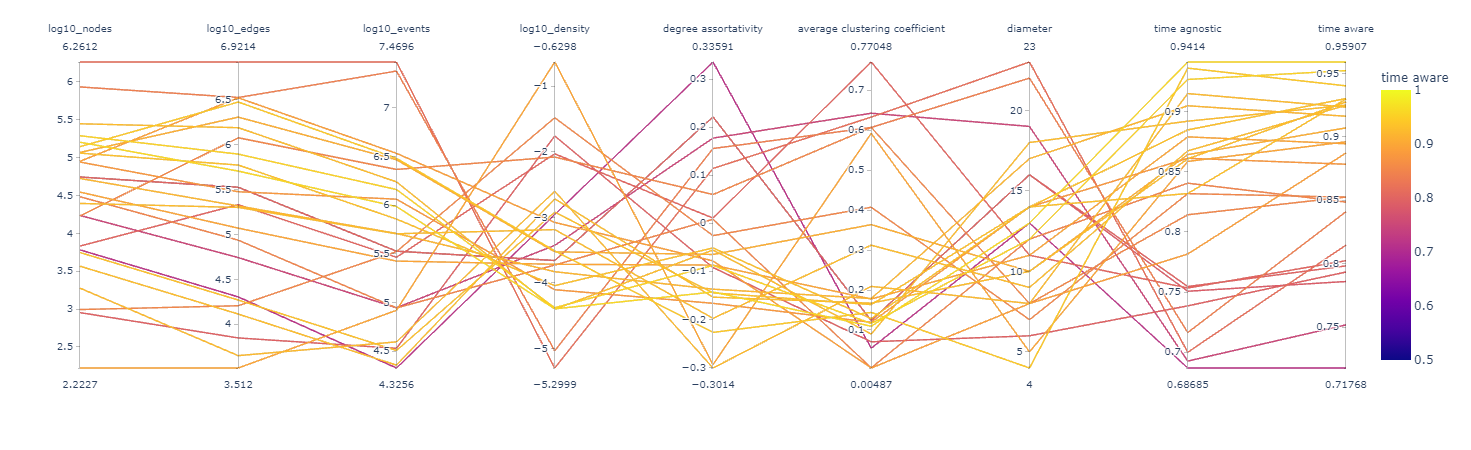

In [33]:
import plotly.express as px
fig = px.parallel_coordinates(
  df.assign(log10_nodes=np.log10(df['nodes']), 
            log10_edges=np.log10(df['edges']),
            log10_events=np.log10(df['events']),
            log10_density=np.log10(df['density'])), 
  ['log10_nodes', 'log10_edges', 'log10_events', 'log10_density', 
   'degree assortativity', 
   'average clustering coefficient', 'diameter', 'time agnostic', 
   'time aware'], 
  color='time aware',
  range_color=(.5,1))
fig

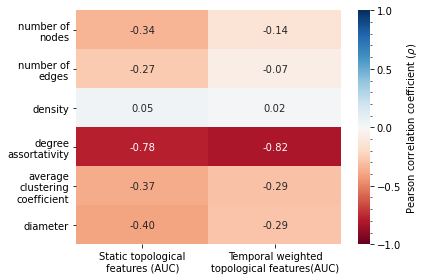

In [53]:
data = (
  df.corr()
  .loc[['time agnostic', 'time aware']]
  .T
  .drop(index=['time aware', 'time agnostic','events'])
  .rename(
    index={
      'nodes': 'number of\nnodes',
      'edges': 'number of\nedges',
      'average clustering coefficient': 'average\nclustering\ncoefficient',
      'degree assortativity': 'degree\nassortativity'
    },
    columns={
      'time agnostic': 'Static topological\nfeatures (AUC)',
      'time aware': 'Temporal weighted\ntopological features(AUC)' 
    }
  )
)

ax = sns.heatmap(data, vmin=-1, vmax=1, annot=True, fmt='.2f', cmap='RdBu', 
                 cbar_kws=dict(label=r'Pearson correlation coefficient ($\rho$)'))
cbar = ax.collections[0].colorbar
cbar.ax.yaxis.set_ticks(np.arange(-1, 1.1, .5))
cbar.ax.yaxis.set_ticks(np.arange(-1, 1.1, .1), minor=True)
plt.yticks(rotation=0) 
plt.tight_layout()
plt.savefig('code/figures/output/correlation.pdf')

In [51]:
from scipy.stats.stats import pearsonr
for column1 in df.columns:
  if column1 in ['nodes', 'edges', 'density', 'degree assortativity', 'average clustering coefficient', 'diameter']:
    for column2 in df.columns:
      if column2 in ['time agnostic', 'time aware']:
        print(column1, column2, pearsonr(df[column1], df[column2]))

nodes time agnostic (-0.3360185586117512, 0.09328795202445073)
nodes time aware (-0.1402090770807605, 0.49450926470993745)
edges time agnostic (-0.26544555211756393, 0.18999167009497575)
edges time aware (-0.07170333026664058, 0.7277772858639548)
density time agnostic (0.04647588621388094, 0.821630821651618)
density time aware (0.020272141782821634, 0.9216987637575066)
degree assortativity time agnostic (-0.7779135333517087, 2.9056392334138697e-06)
degree assortativity time aware (-0.8185953203006654, 3.213394421171203e-07)
average clustering coefficient time agnostic (-0.37078960324377724, 0.06221209089319714)
average clustering coefficient time aware (-0.2911156939392065, 0.14905764863878884)
diameter time agnostic (-0.39886354664950724, 0.04354573069015226)
diameter time aware (-0.28780021484378243, 0.15395588777536517)


In [47]:
df

,nodes,edges,events,density,degree assortativity,average clustering coefficient,diameter,time agnostic,time aware
1,1824701,8344615,29487744,0.000005,0.114186,0.632629,23,0.695059,0.805034
2,16959,1194440,2322259,0.008307,0.059906,0.606845,8,0.815883,0.857692
3,87273,299220,1148072,0.000079,-0.166689,0.119342,14,0.852915,0.880702
4,55387,335708,335708,0.000219,0.221522,0.123693,16,0.768035,0.786416
5,17218,55276,88090,0.000373,0.177355,0.642282,19,0.689612,0.748245
6,6798,214693,290597,0.009293,0.010808,0.770476,11,0.764571,0.809086
7,855165,3358827,23787273,0.000009,0.155727,0.606712,22,0.713769,0.838400
8,55387,335708,335708,0.000219,0.221522,0.123693,16,0.762190,0.796533
9,30398,86312,87627,0.000187,0.008341,0.005286,12,0.841632,0.846188
10,279374,1546540,1729983,0.000040,-0.055707,0.089571,18,0.895661,0.921608


(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]),
 [Text(0, 0.5, 'nodes'),
  Text(0, 1.5, 'edges'),
  Text(0, 2.5, 'events'),
  Text(0, 3.5, 'density'),
  Text(0, 4.5, 'degree assortativity'),
  Text(0, 5.5, 'average clustering coefficient'),
  Text(0, 6.5, 'diameter'),
  Text(0, 7.5, 'I'),
  Text(0, 8.5, 'I+II'),
  Text(0, 9.5, 'III')])

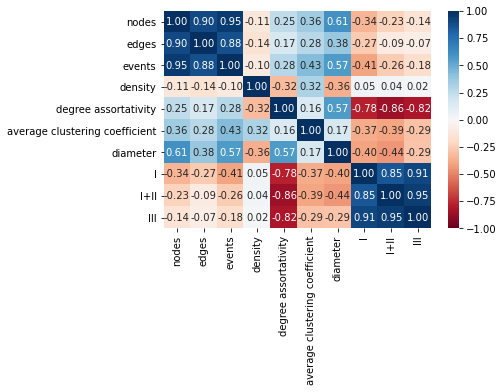

In [39]:
df = pd.concat([
  size,
  stats,
  pd.Series(diameter, name='diameter'),
  pd.Series(auc_I, name='I'),
  pd.Series(auc_I_II, name='I+II'),
  pd.Series(auc_III, name='III')
], axis=1)

sns.heatmap(
  df.corr(),
  vmin=-1, vmax=1, annot=True, fmt='.2f', cmap='RdBu')
plt.yticks(rotation=0) 
# plt.savefig('figures/heatmap.pdf')

In [52]:
df.sort_values('degree assortativity')

,nodes,edges,events,density,degree assortativity,average clustering coefficient,diameter,time agnostic,time aware
19,1891,4465,39264,0.002499,-0.301404,0.209099,8,0.918575,0.926808
12,167,3251,82927,0.234543,-0.294441,0.591863,5,0.853272,0.885753
11,139409,2989657,3018197,0.000308,-0.227284,0.144015,4,0.934950,0.934411
14,24818,199973,506550,0.000649,-0.197902,0.312096,9,0.863147,0.922477
3,87273,299220,1148072,0.000079,-0.166689,0.119342,14,0.852915,0.880702
18,3683,12972,22650,0.001913,-0.153884,0.167077,10,0.866061,0.930870
20,5573,18591,32029,0.001197,-0.144884,0.163569,14,0.831362,0.929366
22,159316,508003,964437,0.000040,-0.143106,0.109331,13,0.938684,0.962611
29,53018,207636,510787,0.000148,-0.137222,0.178697,17,0.907081,0.921457
13,899,7031,33720,0.017419,-0.092248,0.070458,6,0.735070,0.800146
